In [1]:
%%time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import cross_validation, ensemble, tree, metrics, preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
le = preprocessing.LabelEncoder()
import xgboost as xgb
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

CPU times: user 1.37 s, sys: 713 ms, total: 2.08 s
Wall time: 5.46 s


In [2]:
%%time
# Training files are divided into three separate files in six month increments
temp_train_2014_1 = pd.read_csv('CAX_Train_2014_Jan_to_Jun.csv')
temp_train_2014_2 = pd.read_csv('CAX_Train_2014_Jul_to_Dec.csv')
temp_train_2015 = pd.read_csv('CAX_Train_2015.csv')

# Read in the weather file
weather = pd.read_csv('weather.csv')

# The codes file is a manual matching I created between the IATA codes in the training files and
# the ICAO codes in the weather file. Multiple IATA codes can join to the same ICAO codes based on proximity to 
# cities. City names in the training files can be truncated and often did not match the weather file. If the
# matching wasn't obvious based on the IATA and ICAO codes then IATA code were looked up in Google to determine the
# nearest ICAO city.
codes = pd.read_csv('training_weather_cities_joined.csv')

CPU times: user 47.5 s, sys: 9.44 s, total: 57 s
Wall time: 57.7 s


In [3]:
%%time
# Creating week of year field in order to group weather events by week
weather['week_of_year'] = pd.to_datetime(weather['date'], errors='coerce').dt.weekofyear.astype(int)

# Some basic munging of weather fields
weather.events.fillna(-1, inplace=True)
weather.conditions.fillna(-1, inplace=True)
weather.gust_speed_mph.replace('-', -1, inplace=True)
weather.gust_speed_mph.fillna(-1, inplace=True)
weather.gust_speed_mph = pd.to_numeric(weather.gust_speed_mph, errors='coerce')
weather.wind_speed_mph.replace('Calm', 0, inplace=True)
weather.wind_speed_mph.fillna(-1, inplace=True)
weather.wind_speed_mph = pd.to_numeric(weather.wind_speed_mph, errors='coerce')

# Changing to weather types in the events field to numeric values based on the likelihood of causing delays
# e.g. Events involving ice have a higher value
weather.events.replace(['Fog',
'Fog-Hail-Thunderstorm',
'Fog-Rain',
'Fog-Rain-Hail-Thunderstorm',
'Fog-Rain-Snow',
'Fog-Rain-Thunderstorm',
'Fog-Rain-Thunderstorm-Tornado',
'Fog-Snow',
'Fog-Snow-Thunderstorm',
'Fog-Thunderstorm',
'Hail',
'Hail-Thunderstorm',
'Rain',
'Rain-Hail',
'Rain-Hail-Thunderstorm',
'Rain-Snow',
'Rain-Snow-Thunderstorm',
'Rain-Thunderstorm',
'Rain-Thunderstorm-Tornado',
'Rain-Tornado',
'Snow',
'Snow-Hail',
'Snow-Thunderstorm',
'Snow-Tornado',
'Thunderstorm',
'Thunderstorm-Tornado',
'Tornado'], [10,
80,
20,
80,
60,
50,
100,
60,
60,
50,
80,
80,
20,
80,
80,
60,
60,
50,
100,
100,
60,
80,
60,
100,
50,
100,
100], inplace=True)

# As with the events field, changing the conditions field to numeric values based on the likelihood of causing delays
weather.conditions.replace(['Unknown',
'Clear',
'Overcast',
'Partly Cloudy',
'Drizzle',
'Scattered Clouds',
'Mostly Cloudy',
'Haze',
'Mist',
'Patches of Fog',
'Rain',
'Shallow Fog',
'Low Drifting Snow',
'Rain Showers',
'Light Blowing Snow',
'Light Drizzle',
'Light Fog',
'Light Hail',
'Light Ice Pellets',
'Light Low Drifting Snow',
'Light Mist',
'Light Rain',
'Light Rain Showers',
'Light Sand',
'Light Small Hail Showers',
'Light Smoke',
'Light Snow',
'Light Snow Grains',
'Light Snow Showers',
'Light Thunderstorm',
'Light Thunderstorms and Rain',
'Light Thunderstorms and Snow',
'Light Thunderstorms with Hail',
'Light Thunderstorms with Small Hail',
'Heavy Blowing Snow',
'Heavy Drizzle',
'Heavy Freezing Drizzle',
'Heavy Freezing Fog',
'Heavy Freezing Rain',
'Heavy Ice Pellets',
'Heavy Rain',
'Heavy Rain Showers',
'Heavy Small Hail',
'Heavy Snow',
'Heavy Snow Showers',
'Heavy Thunderstorm',
'Heavy Thunderstorms and Rain',
'Heavy Thunderstorms and Snow',
'Heavy Thunderstorms with Hail',
'Heavy Thunderstorms with Small Hail',
'Ice Crystals',
'Ice Pellets',
'Funnel Cloud',
'Blowing Sand',
'Blowing Snow',
'Thunderstorm',
'Thunderstorms and Rain',
'Thunderstorms and Snow',
'Thunderstorms with Hail',
'Thunderstorms with Small Hail',
'Volcanic Ash',
'Widespread Dust',
'Sand',
'Sandstorm',
'Small Hail',
'Small Hail Showers',
'Smoke',
'Snow',
'Snow Grains',
'Snow Showers',
'Squalls',
'Fog',
'Freezing Rain',
'Hail',
'Light Freezing Drizzle',
'Light Freezing Fog',
'Light Freezing Rain'], [-1,
0,
0,
0,
10,
0,
0,
0,
0,
10,
10,
10,
30,
10,
30,
10,
10,
50,
70,
30,
0,
10,
10,
30,
50,
20,
30,
70,
30,
20,
20,
40,
60,
60,
80,
20,
70,
70,
90,
80,
20,
20,
70,
80,
80,
50,
30,
80,
80,
80,
70,
70,
90,
70,
70,
40,
30,
70,
80,
80,
100,
20,
60,
80,
60,
70,
20,
60,
60,
60,
70,
10,
80,
50,
60,
50,
80], inplace=True)

CPU times: user 1min, sys: 3.87 s, total: 1min 4s
Wall time: 1min 4s


In [4]:
%%time
# Grouping the weather features by week of year
weather_group = weather.groupby( [ 'airport_code', 'week_of_year'] ).mean()
weather_group = weather_group.reset_index()
weather_group = weather_group.drop('zip', 1)
weather_group.fillna(-1, inplace=True)

CPU times: user 1.8 s, sys: 1.31 s, total: 3.1 s
Wall time: 3.24 s


In [5]:
%%time
# This array defines the dates of holidays in 2014 and 2015
holidays = [
        date(2014, 1, 1), date(2014, 1, 20), date(2014, 5, 26), date(2014, 7, 4), \
        date(2014, 9, 1), date(2014, 11, 27), date(2014, 12, 25), \
        date(2015, 1, 1), date(2015, 1, 19), date(2015, 5, 25), date(2015, 7, 4), \
        date(2015, 9, 7), date(2015, 11, 26), date(2015, 12, 25) \
     ]

#Function that gives the number of days from a date to the nearest holiday
def days_from_nearest_holiday(year, month, day):
  d = date(year, month, day)
  x = [(abs(d-h)).days for h in holidays]
  return min(x)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 11.9 µs


In [6]:
%%time
# Combine all of the training files into one dataframe
training = pd.concat([temp_train_2014_1, temp_train_2014_2, temp_train_2015], ignore_index=True)

CPU times: user 2.23 s, sys: 2.51 s, total: 4.74 s
Wall time: 5.34 s


In [7]:
%%time
# Merge the codes file to get the IACO codes for the origin IATA code
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], left_on='ORIGIN', right_on='ORIGIN')
training.rename(columns={'city': 'origin_city', 'airport_code': 'origin_icao_code'}, inplace=True)

# Merge the codes file to get the IACO codes for the destination IATA code
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], left_on='DEST', right_on='ORIGIN')
training.rename(columns={'city': 'dest_city', 'airport_code': 'dest_icao_code', 'ORIGIN_x': 'ORIGIN'}, inplace=True)
training = training.drop('ORIGIN_y', 1)

# Create day, week, and hour features from the flight date
training['DAY_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.dayofyear.astype(int)
training['WEEK_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.weekofyear.astype(int)
training['hour'] = training['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[:2]))
training['day'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.day.astype(int)

# Create the days from holiday feature using the function defined earlier
training['days_from_holidays'] = [days_from_nearest_holiday(r.YEAR, r.MONTH, r.day) for i,r in training.iterrows()]

# Merge the weather data with the training data on the origin and week of year
training = pd.merge(training, weather_group, left_on=['origin_icao_code', 'WEEK_OF_YEAR'], right_on=['airport_code', 'week_of_year'], how='left')
training.rename(columns={'conditions': 'orig_conditions', 'airport_code': 'orig_airport_code', 'week_of_year': 'orig_week_of_year', 'temperature_f': 'orig_temperature_f', 'dew_point_f': 'orig_dew_point_f', 'humidity': 'orig_humidity', 'sea_level_pressure_in': 'orig_sea_level_pressure_in', 'visibility_mph': 'orig_visibility_mph', 'wind_speed_mph': 'orig_wind_speed_mph', 'gust_speed_mph': 'orig_gust_speed_mph', 'precipitation_in': 'orig_precipitation_in', 'events': 'orig_events', 'wind_dir_degrees': 'orig_wind_dir_degrees', 'event_names': 'orig_event_names', 'condition_names': 'orig_condition_names'}, inplace=True)

# Merge the weather data with the training data on the destination and week of year
training = pd.merge(training, weather_group, left_on=['dest_icao_code', 'WEEK_OF_YEAR'], right_on=['airport_code', 'week_of_year'], how='left')
training.rename(columns={'conditions': 'dest_conditions', 'airport_code': 'dest_airport_code', 'week_of_year': 'dest_week_of_year', 'temperature_f': 'dest_temperature_f', 'dew_point_f': 'dest_dew_point_f', 'humidity': 'dest_humidity', 'sea_level_pressure_in': 'dest_sea_level_pressure_in', 'visibility_mph': 'dest_visibility_mph', 'wind_speed_mph': 'dest_wind_speed_mph', 'gust_speed_mph': 'dest_gust_speed_mph', 'precipitation_in': 'dest_precipitation_in', 'events': 'dest_events', 'wind_dir_degrees': 'dest_wind_dir_degrees', 'event_names': 'dest_event_names', 'condition_names': 'dest_condition_names'}, inplace=True)

training.fillna(-1, inplace=True)

CPU times: user 15min 27s, sys: 1min 29s, total: 16min 57s
Wall time: 17min 6s


In [8]:
%%time
#Define the features to use
features = [c for c in training.columns if c in ['days_from_holidays', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE', 'hour', 'orig_temperature_f', 'orig_dew_point_f', 'orig_humidity', 'orig_sea_level_pressure_in', 'orig_visibility_mph', 'orig_wind_speed_mph', 'orig_gust_speed_mph', 'orig_precipitation_in', 'orig_events', 'orig_conditions', 'orig_wind_dir_degrees', 'dest_temperature_f', 'dest_dew_point_f', 'dest_humidity', 'dest_sea_level_pressure_in', 'dest_visibility_mph', 'dest_wind_speed_mph', 'dest_gust_speed_mph', 'dest_precipitation_in', 'dest_events', 'dest_conditions', 'dest_wind_dir_degrees']]

CPU times: user 230 µs, sys: 724 µs, total: 954 µs
Wall time: 934 µs


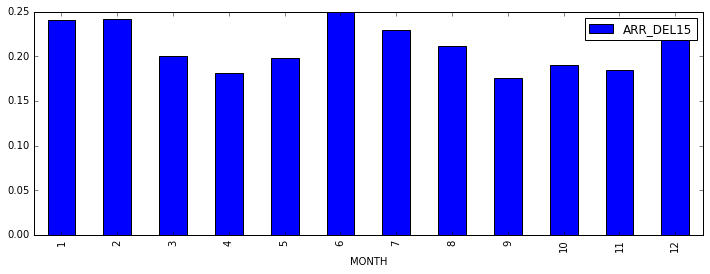

In [9]:
# Compute average number of delayed flights per month
grouped = training[['ARR_DEL15', 'MONTH']].groupby('MONTH').mean()

# plot average delays by month
grouped.plot(kind='bar')

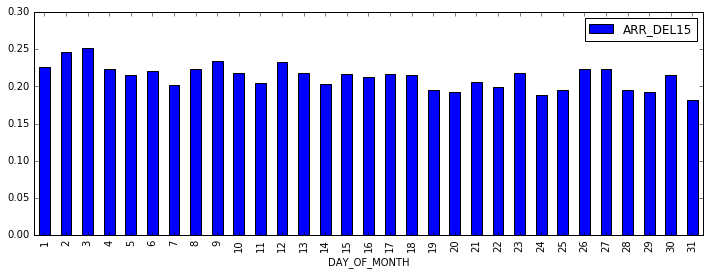

In [10]:
# Compute average number of delayed flights per month
grouped = training[['ARR_DEL15', 'DAY_OF_MONTH']].groupby('DAY_OF_MONTH').mean()

# plot average delays by month
grouped.plot(kind='bar')

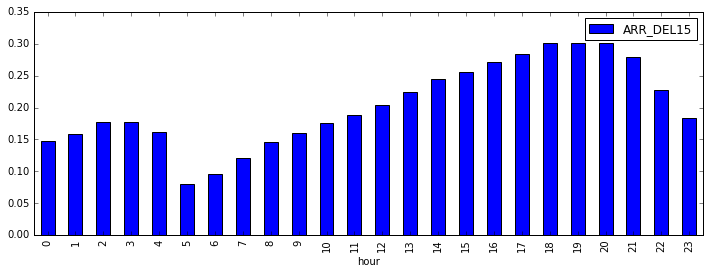

In [11]:
# Compute average number of delayed flights by hour
grouped = training[['ARR_DEL15', 'hour']].groupby('hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')

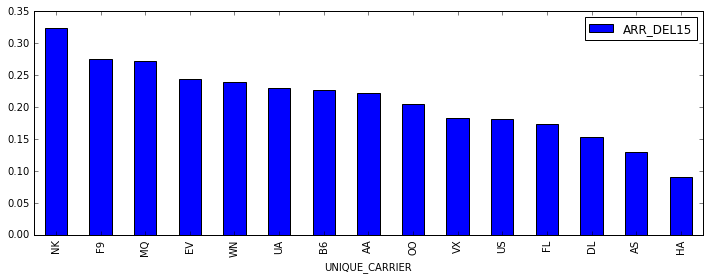

In [12]:
# Compute average number of delayed flights per carrier
grouped1 = training[['ARR_DEL15', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').filter(lambda x: len(x)>15)
grouped2 = grouped1.groupby('UNIQUE_CARRIER').mean()
carrier = grouped2.sort(['ARR_DEL15'], ascending=False)

# display top 15 destination carriers by delay
carrier.plot(kind='bar')

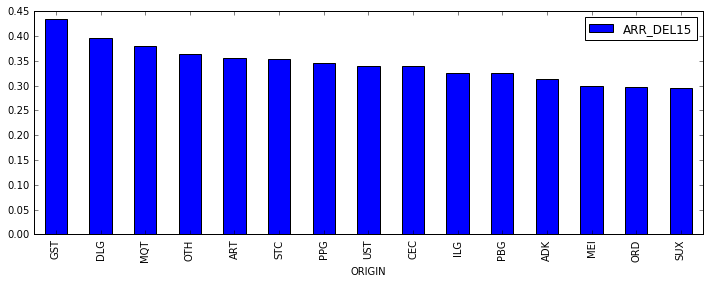

In [13]:
# Compute average number of delayed flights per origin airport
grouped1 = training[['ARR_DEL15', 'ORIGIN']].groupby('ORIGIN').filter(lambda x: len(x)>15)
grouped2 = grouped1.groupby('ORIGIN').mean()
carrier = grouped2.sort(['ARR_DEL15'], ascending=False)

# display top 15 origin airports by delay
carrier[:15].plot(kind='bar')

In [ ]:
# There's a large difference in the amount of data for delayed vs. on time flights
print len(training[training['ARR_DEL15'] == 1]), len(training[training['ARR_DEL15'] == 0])

In [ ]:
%%time
# Reduce the number of on time training instances so that the model will fit more easily into memory
# Keep all delayed instances and take random instances of on time flights equal to 1.5 times the number of
# delayed instances
delayed = training[training['ARR_DEL15'] == 1]
on_time = training[training['ARR_DEL15'] == 0]
sample_rows = np.random.choice(on_time.index.values, (len(delayed) * 1.5))
on_time = on_time.ix[sample_rows]
training = pd.concat([on_time, delayed], ignore_index=True)

In [ ]:
%%time
# Transform the string labels to numerical using label encoder 
training.UNIQUE_CARRIER = le.fit_transform(training.UNIQUE_CARRIER)
training.ORIGIN = le.fit_transform(training.ORIGIN)
training.DEST = le.fit_transform(training.DEST)

In [ ]:
%%time
# Create training and testing sets using cross validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(training[features], training['ARR_DEL15'], test_size=0.70)

In [ ]:
%%time
categ = [list(features_train.columns).index(x) for x in 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'hour']
enc = OneHotEncoder(categorical_features = categ)
features_train['UNIQUE_CARRIER'] = pd.factorize(features_train['UNIQUE_CARRIER'])[0]
features_train['ORIGIN'] = pd.factorize(features_train['ORIGIN'])[0]
features_train['DEST'] = pd.factorize(features_train['DEST'])[0]
features_train = enc.fit_transform(features_train)

features_test['UNIQUE_CARRIER'] = pd.factorize(features_test['UNIQUE_CARRIER'])[0]
features_test['ORIGIN'] = pd.factorize(features_test['ORIGIN'])[0]
features_test['DEST'] = pd.factorize(features_test['DEST'])[0]
features_test = enc.transform(features_test)

print features_train.shape

In [ ]:
%%time
def modelfit(alg, features, labels, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(features.values, label=labels.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(features, labels, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features)
    dtrain_predprob = alg.predict_proba(features)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(labels.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(labels, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
%%time
xgb_final =  xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(features_train.values, labels_train.values)

In [ ]:
%%time
#d_tree = tree.DecisionTreeClassifier(min_samples_split=1000).fit(features_train, labels_train)
# Best so far: clf_rf = ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=50).fit(features_train, labels_train)
forest = ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1).fit(features_train, labels_train)
# naive = GaussianNB().fit(features_train, labels_train)

In [ ]:
%%time
# Evaluate on test set
pred = xgb_final.predict(features_test)
# pred = d_tree.predict(features_test)
# pred = forest.predict(features_test)
# pred = naive.predict(features_test)


# print results
cm = confusion_matrix(labels_test, pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

report_rf = precision_recall_fscore_support(list(labels_test), list(pred), average='micro')
print "precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], metrics.roc_auc_score(list(labels_test.values), list(pred)))